# Basic tutorial for query to reference maping using expiMap

Also see the advanced tutorial to learn about adding constrained and unconstrained extension nodes to the query to capture new sources of variation, that is new and de novo gene programs, not in the reference dataset.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download reference and do preprocessing

In [4]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
To: C:\Users\sergei.rybakov\projects\notebooks\pbmc_tutorial.h5ad
100%|███████████████████████████████████████████████████████████████████████████████| 231M/231M [00:42<00:00, 5.39MB/s]


'pbmc_tutorial.h5ad'

In [6]:
adata = sc.read('pbmc_tutorial.h5ad')

`.X` should contain raw counts.

In [5]:
adata.X = adata.layers["counts"].copy()

Read the Reactome annotations, make a binary matrix where rows represent gene symbols and columns represent the terms, and add the annotations matrix to the reference dataset. The binary matrix of annotations is stored in `adata.varm['I']`. Note that only terms with minimum of 12 genes in the reference dataset are retained.

In [ ]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

In [6]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

Remove all genes which are not present in the Reactome annotations.

In [7]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to 2000 here. However, for more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [8]:
sc.pp.normalize_total(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out all annotations (terms) with less than 12 genes.

In [11]:
select_terms = adata.varm['I'].sum(0)>12

In [12]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [13]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any of the terms after selection of HVGs.

In [14]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put the counts data back to `adata.X`.

In [15]:
adata.X = adata.layers["counts"].copy()

### Create expiMap model and train it on reference dataset

In [16]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


Set the `alpha` hyperparameter. This regulates the strength of group lasso regularization of annotations (terms). Higher value means that a larger number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

See also https://docs.scarches.org/en/latest/training_tips.html for the recommendation on hyperparameter choice.

In [1]:
ALPHA = 0.7

In [18]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |████████------------| 41.8%  - epoch_loss: 875.0875513335 - epoch_recon_loss: 849.8969689248 - epoch_kl_loss: 50.3811637679 - val_loss: 938.5590139536 - val_recon_loss: 912.9722806490 - val_kl_loss: 51.17346543531427418
ADJUSTED LR
 |█████████-----------| 46.0%  - epoch_loss: 867.2534920638 - epoch_recon_loss: 842.2286955321 - epoch_kl_loss: 50.0495922638 - val_loss: 939.3953810472 - val_recon_loss: 913.6503906250 - val_kl_loss: 51.4899893541
ADJUSTED LR
 |██████████----------| 50.5%  - epoch_loss: 868.1691942506 - epoch_recon_loss: 843.1531918455 - epoch_kl_loss: 50.0320032611 - val_loss: 937.6233802209 - val_recon_loss: 911.8207420936 - val_kl_loss: 51.6052835905
ADJUSTED LR
 |████████████--------| 60.2%  - epoch_loss: 874.0884924476 - epoch_recon_loss: 848.9184943453 - epoch_kl_loss: 50.3399958715 - val_loss: 938.2763272799 - val_recon_loss: 912.5495535044 - val_kl_loss: 51.4535569411
ADJUSTED LR
 |████████████--------| 63

In [16]:
MEAN = False

Plot the latent space of the reference.

In [20]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [21]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [22]:
sc.tl.umap(adata)

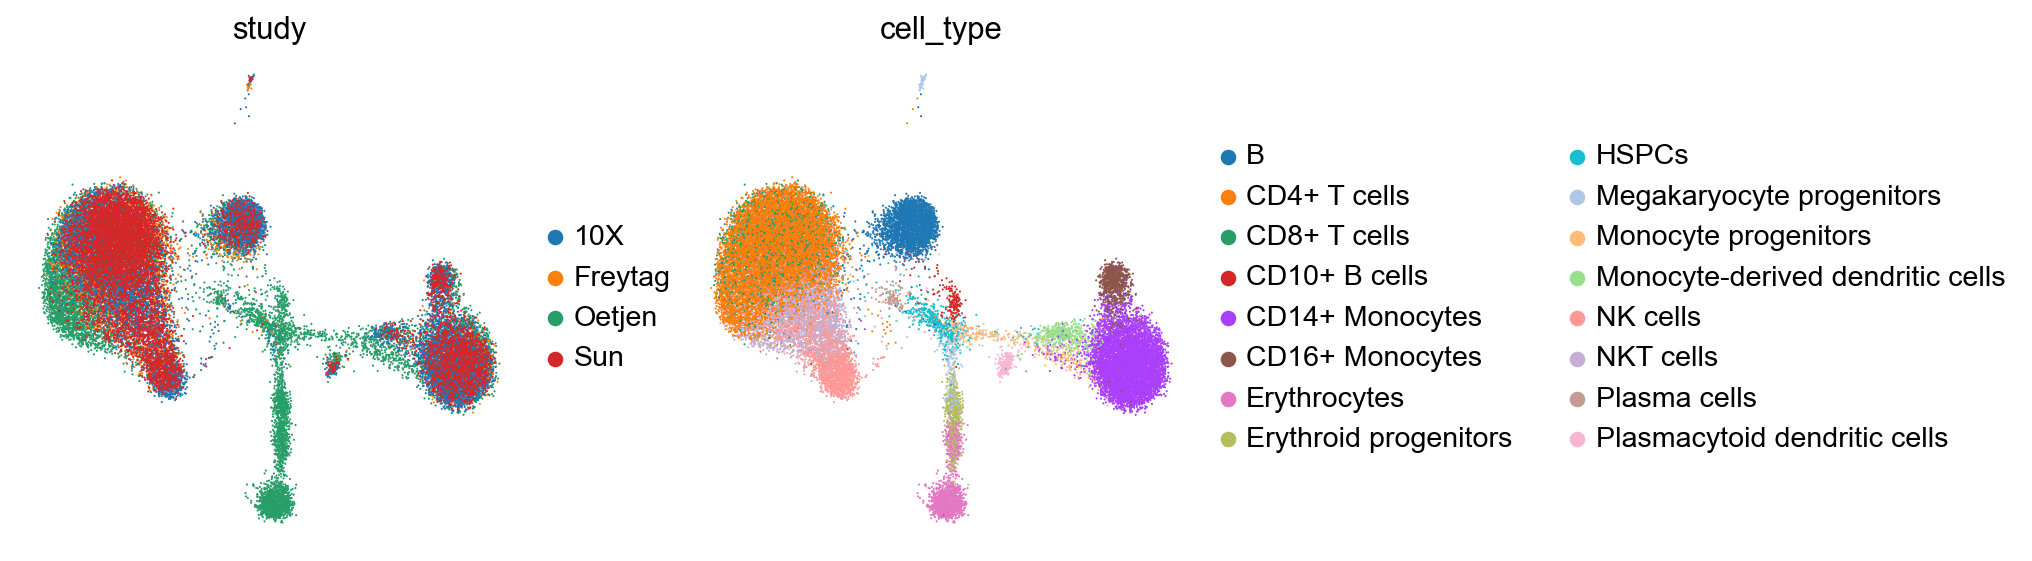

In [23]:
sc.pl.umap(adata, color=['study', 'cell_type'], frameon=False)

### Downaload the query dataset for reference mapping

The Kang dataset contains control and IFN-beta stimulated cells. We use this as the query dataset.

In [ ]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

In [17]:
kang = sc.read('kang_tutorial.h5ad')[:, adata.var_names].copy()

In [18]:
kang.obs['study'] = 'Kang'

In [19]:
kang.uns['terms'] = adata.uns['terms']

### Initlizling the model for query training

In [27]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 5 1972
	with hard mask.
Last Decoder layer: softmax


In [28]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

 |████████------------| 41.2%  - val_loss: 519.4205793901 - val_recon_loss: 512.4798778187 - val_kl_loss: 69.40706010300
ADJUSTED LR
 |████████------------| 43.0%  - val_loss: 520.2541309703 - val_recon_loss: 513.2979486639 - val_kl_loss: 69.5618133545
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 150


Save your model.

In [ ]:
q_intr_cvae.save('query_kang_tutorial')

### Get latent representation of reference + query dataset

In [33]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [34]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN, only_active=True)

In [35]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [36]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'cell_type' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'condition_joint' as categorical


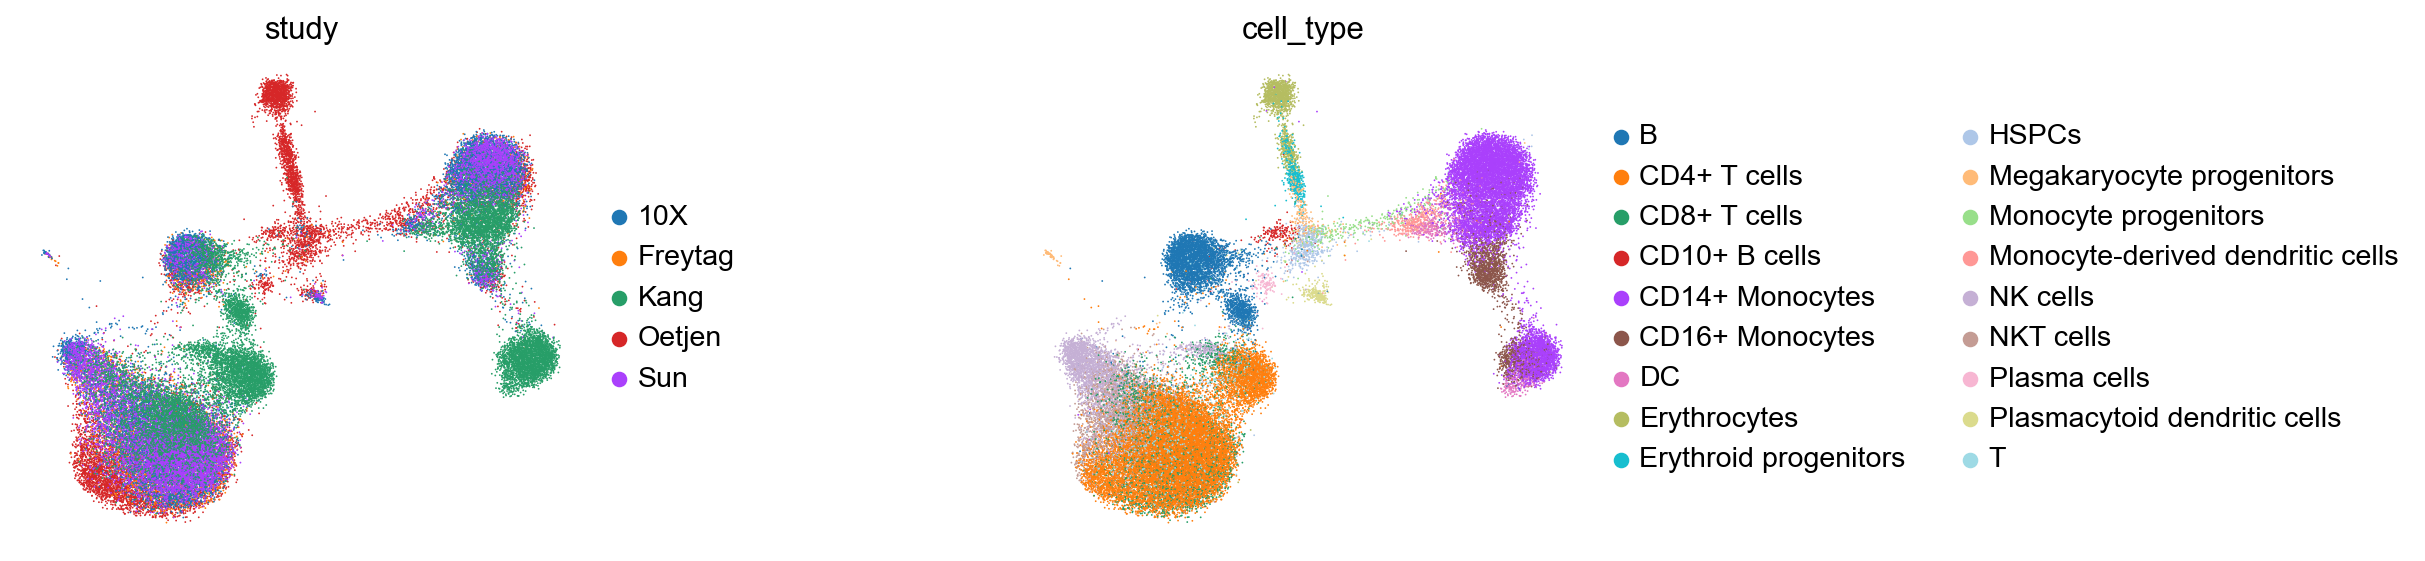

In [37]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type'], frameon=False, wspace=0.6)

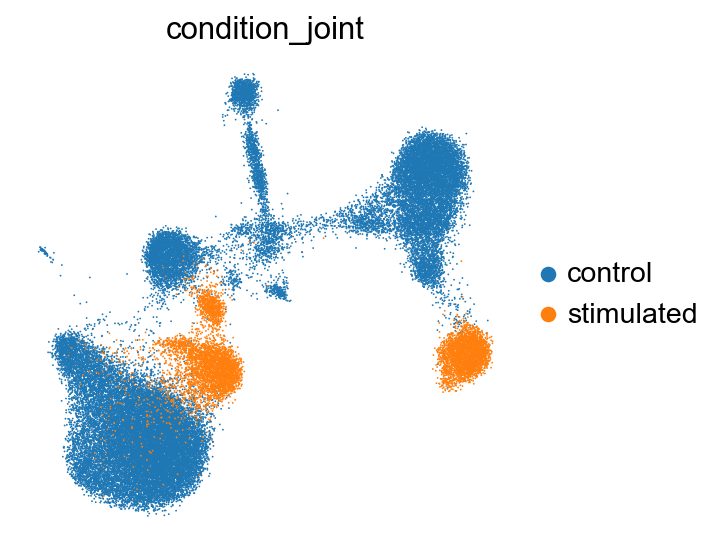

In [38]:
sc.pl.umap(kang_pbmc, color='condition_joint', frameon=False, wspace=0.6)

Calculate directions of upregulation for each latent score and put them to `kang_pbmc.uns['directions']`.

In [39]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for condition in reference + query using Bayes Factors.

In [40]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

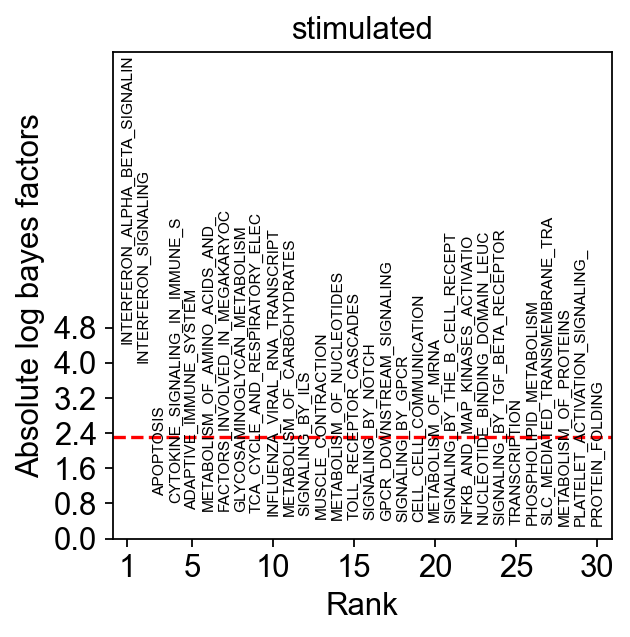

In [41]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

As expected, `INTERFERON_ALPHA_BETA_SIGNALING` is the top differential program in stimulated compared to control cells.

Plot the latent variables for query + reference corresponding to the annotations 'INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPTOR', 'INTERFERON_ALPHA_BETA_SIGNALING'.

In [42]:
terms = kang_pbmc.uns['terms']
select_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'SIGNALING_BY_THE_B_CELL_RECEPT']
idx = [terms.index(term) for term in select_terms]

Multiplying the latent varibales by the calculated directons to ensure positive latent scores corresponf to upregulation. 

In [43]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN) * kang_pbmc.uns['directions'])[:, idx]

In [44]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 1]

kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 2]

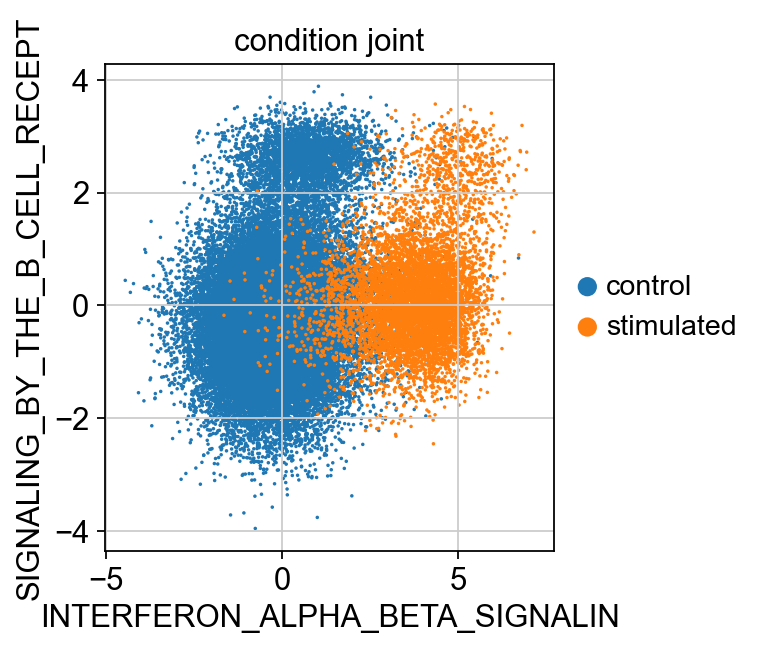

In [45]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=10)

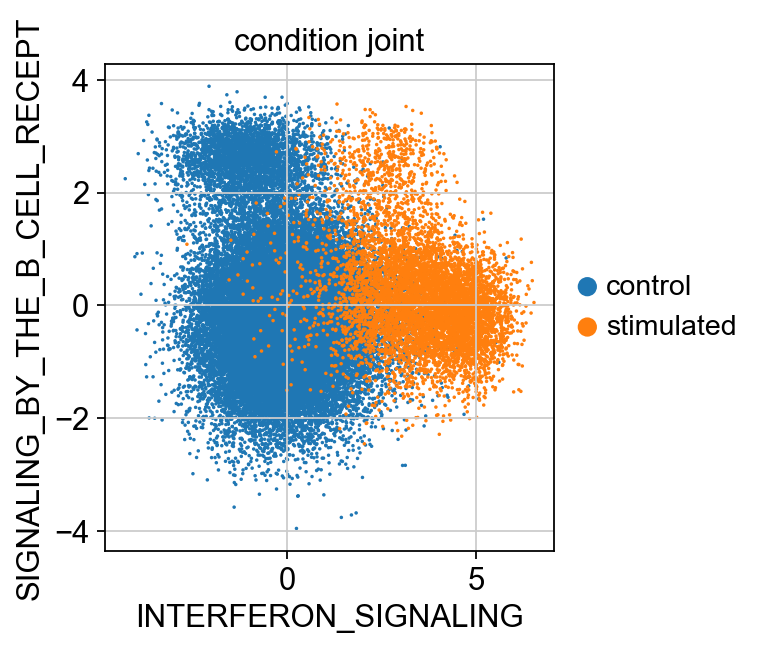

In [46]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=10)

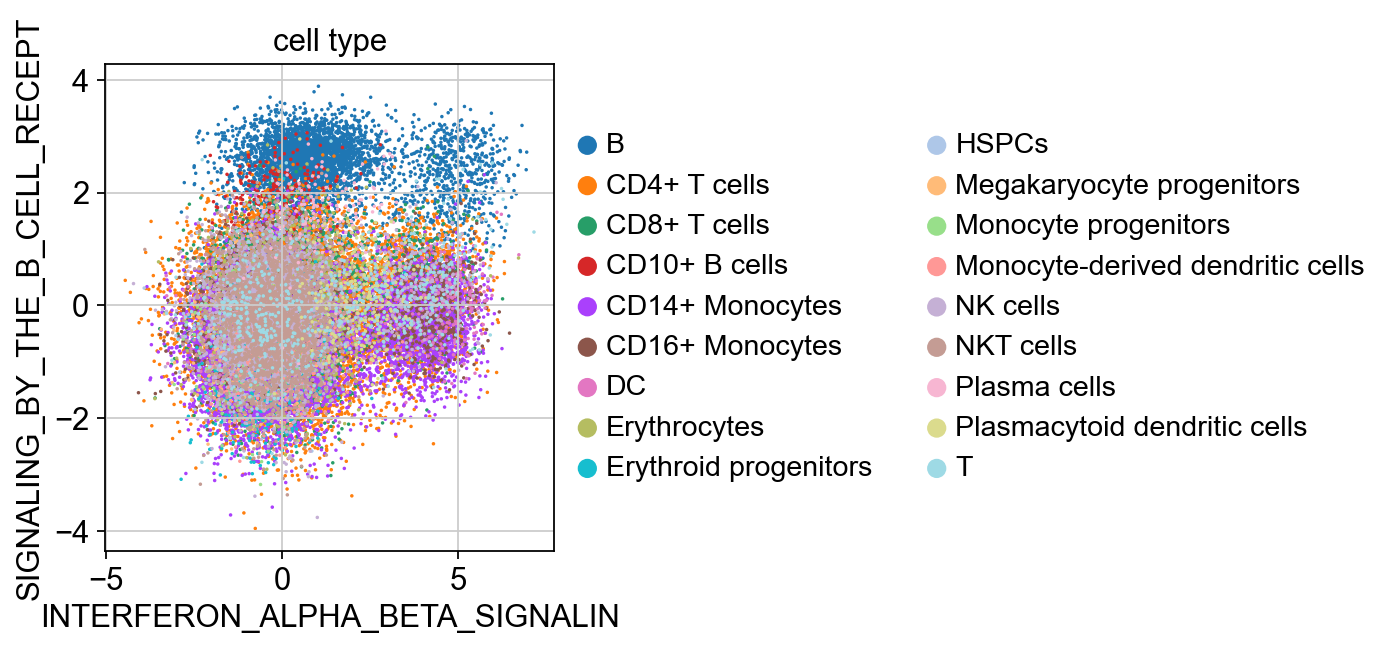

In [47]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=10)